# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

Сначала импортируем библиотеки которые нам могут понадобиться в процессе рабоды над проектом.

In [1]:
import pandas as pd
import numpy as np
import joblib
from joblib import dump
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier


Откроем файл /datasets/users_behavior.csv просмотрим датасет и информацию по данным в датасете.

In [2]:
data = pd.read_csv('/datasets/users_behavior.csv')
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


**Вывод:**<br>
Датасет состоит из 3214 строк и 5 колонок. Пропусков в значениях нет, наименования столбцов указаны корректно.<br>
- в столбце `calls` данные по количеству звонков. Тип данных 'float', хотя по природе данных количество звонков должно быть целым числом 'int'. Максимальное значение равно 244, медианное значение равно 62, а среднее значение равно 63 <br>
- в столбце `minutes` данные о количестве потраченых на разговоры минут. Тип данных 'float'. Максимальное значение равно 1632, медианное значение равно 431, а среднее значение равно 438 <br>
- в столбце `messages` данные по количеству отправленых сообщений. Тип данных 'float', хотя количество сообщений должно быть целым числом 'int'. Максимальное значение равно 244, медианное значение равно 30, а среднее значение равно 38 <br>
- в столбце `mb_used` данные по количеству потраченых mb интернет трафика. Тип данных 'float'. Максимальное значение равно 49746, медианное значение равно 16943, а среднее значение равно 17208 <br>
- в столбце `is_ultra` указана категория используемого тарифа, т.е. пользуется ли тарифом 'Ультра' конкретный пользователь или тарифом 'Смарт'. Cреднее значение 0,31 говорит о том, что  тарифом 'Ультра' пользуются около 31% всех пользователей, а тарифом 'Смарт' соответственно 69% пользователей. Тип данных 'int'. <br>
- В каждом столбце минимальное значение 0.

Мы определили, что данный в столбцах `calls` и `messages` по своей природе должны иметь тип 'int'. Приведем типы дынных в этих столбцах к целочисленному типу. И еще раз проверим информацию по датасету.

In [5]:
# Меняем тип данных
data['calls'] = data['calls'].astype('int')
data['messages'] = data['messages'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


Судя по данным представленным в датафрейме можно предположить что существует связь между количеством звонков и потраченными минутами, т.е. чем больше количество звонков, тем больше потрачено минут. Проверим эту зависимость построим графики и посчитаем корреляцию для данных в столбцах `calls` и `minutes`.

0.9820832355742293

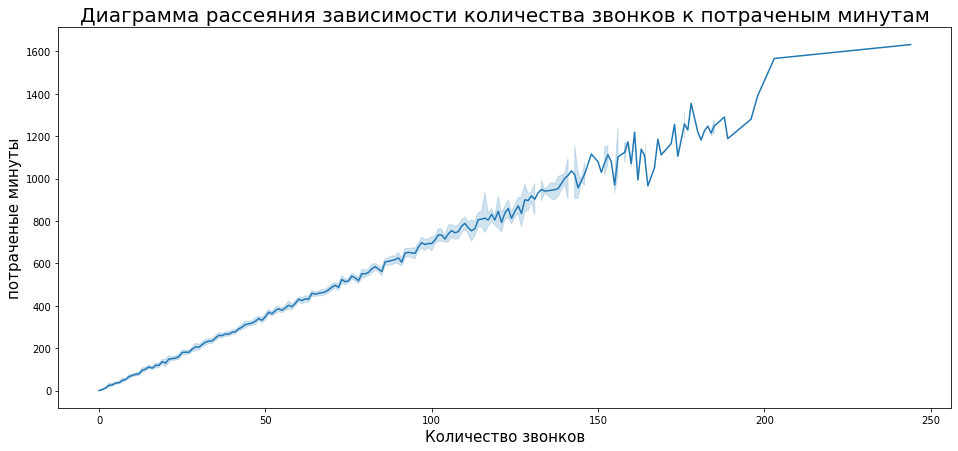

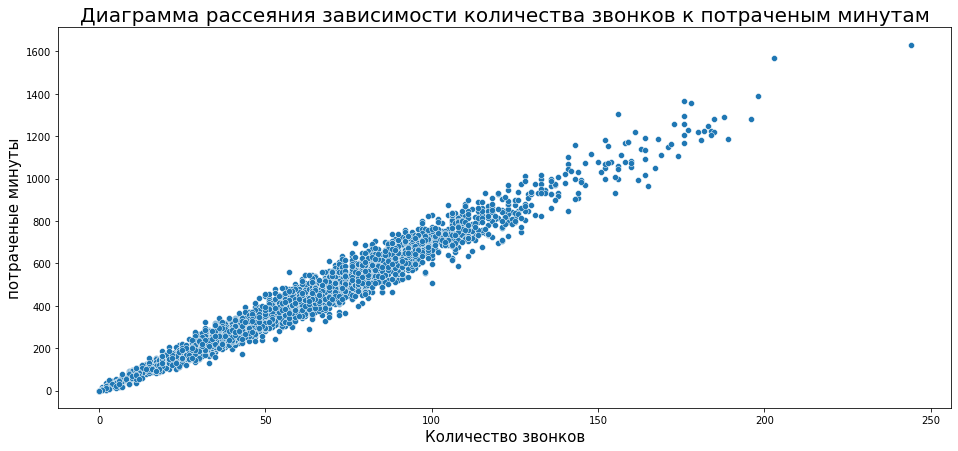

In [6]:
plt.figure(figsize=(16,7))
sns.lineplot(x=data['calls'],y=data['minutes'])
plt.title('Диаграмма рассеяния зависимости количества звонков к потраченым минутам', fontsize=20)
plt.xlabel('Количество звонков',fontsize=15)
plt.ylabel('потраченые минуты',fontsize=15)


plt.figure(figsize=(16,7))
sns.scatterplot(x=data['calls'],y=data['minutes'])
plt.title('Диаграмма рассеяния зависимости количества звонков к потраченым минутам', fontsize=20)
plt.xlabel('Количество звонков',fontsize=15)
plt.ylabel('потраченые минуты',fontsize=15)
# Подсчет корреляции
data['calls'].corr(data['minutes'])

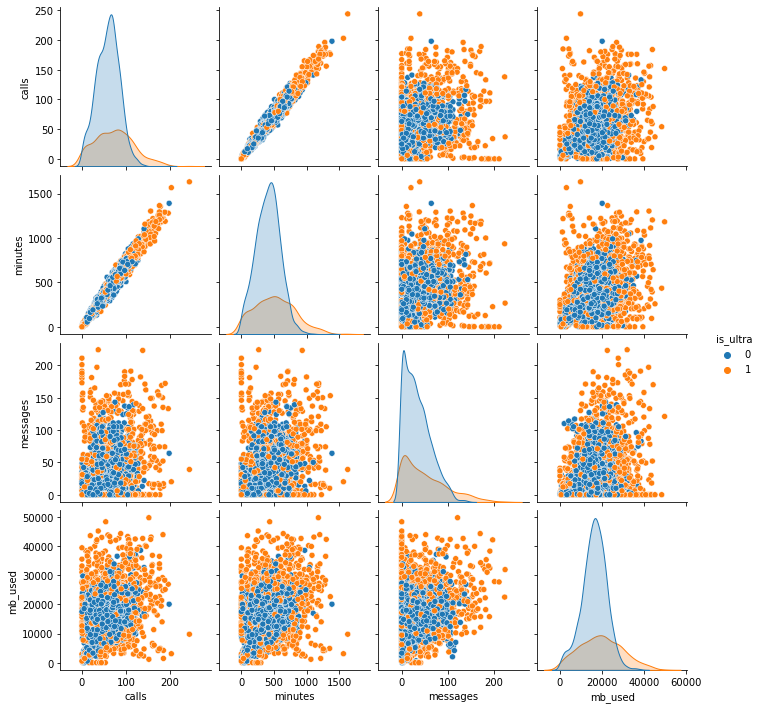

In [7]:
sns.pairplot(data, hue='is_ultra')

Да, действительно в данных присутствует тесная связь между количеством звонков и количеством потраченых минут, чем больше звонков, тем больше минут потрачено. Эта связь хорошо видна на графиках, а коэффициет корреляции, близкий к единице это подтверждает.<br>
Подобная связь может негативно повлиять на обучение модели, и с этим надо что-то делать. Так же стоит отметить что в тарифах мобильных операторов количество совершенных звонков не учитывается, а учитывается только их продолжительность. Поэтому данные по количеству звонков, столбец `calls`, можно удалить.

In [8]:
data = data.drop(['calls'], axis=1)
data.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83,19915.42,0
1,516.75,56,22696.96,0
2,467.66,86,21060.45,0
3,745.53,81,8437.39,1
4,418.74,1,14502.75,0


**Вывод:**<br><br>
Мы импортировали необходимы библиотеки.
Просмотрели информацию по всем данным, определили типы данных и поменяли их там где это было необходимо. Выяснили что данных пропусков нет.
А так же выявили взаимосвязь количества звонков и их продолжительности и удалили столбец `calls`, чтобы эта взаимосвязь не повлияла на переобучение модели.

## Разбейте данные на выборки

### Определение признаков 'features' и целевого признака 'target'

Для обучения модели мы будем задавать вопросы, и получать ответы. В нащем датасете этветы это значения столбца `is_ultra`, а значит `is_ultra` это целевой признак target, а признаки features это весь датафрейм без `is_ultra`.

In [9]:
# Признаки
features = data.drop(['is_ultra'], axis=1)
# Целевой признаки
target = data['is_ultra']

### Деление выборки на 3 части

По заданию проекта необходимо разделить исходные данные на три выборки обучающую, валидационную и тестовую.
Так как исходную выботку нужно поделить на три части в соотношении 3:1:1 или 60% обучающая выборка, 20% валидационная и 20% тестовая выбрка, то для начала отделим 40% от общей выборки на валидацию и тест, а затем разделим ее пополам.

In [10]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.4, random_state=12345)
print('Размер обучающей выборки целевого признака:', target_train.shape)
print('Размер тестовой выборки целевого признака:', target_test.shape)


Размер обучающей выборки целевого признака: (1928,)
Размер тестовой выборки целевого признака: (1286,)


Теперь из тестовой выборки выделим часть валидационной, поделив тестовую пополам.

In [11]:
features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, 
                                                                            test_size=0.5, random_state=12345)
print('Размер тестовой выборки целевого признака:', target_test.shape)
print('Размер валидационной выборки целевого признака:', target_valid.shape)


Размер тестовой выборки целевого признака: (643,)
Размер валидационной выборки целевого признака: (643,)


**Вывод:**<br><br>
Исходные данные мы разделили на признаки 'features' и целевой признак 'target'.<br>
Затем получили три выборки признаков и целевого признака.<br>
- Обучающая 'features_train' и 'target_train' размером в 1928 строк, это 60% от исходной выборки.<br>
- Валидационную 'features_valid' и 'target_valid' размером в 643 строки, это 20% от исходной выборки.<br>
- Тестовую 'features_test' и 'target_test' размером в 643 строки, это 20% от исходной выборки.<br>

## Исследуйте модели

Проведем исследование трех моделий обучения "Решающее дерево", "Случайный лес" и "Логическая регрессия" и определим метрику качества каждой модели.

### Модель решающее ререво

Обучим модель "Обучающим деревом", применим функцию DecisionTreeClassifier и определим глубину дерева.

In [12]:
%%time
best_model_tree = None
best_depth_tree = 0
best_result_tree = 0
for depth in range (1,10):
    model_tree = DecisionTreeClassifier(random_state=12345,max_depth=depth)
    model_tree.fit(features_train,target_train)
    predictions_valid = model_tree.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    if result > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result
        best_depth_tree = depth

print('Лучшее значение accuracy:',best_result_tree)
print('Лучшая глубина дерева:', best_depth_tree)

Лучшее значение accuracy: 0.7962674961119751
Лучшая глубина дерева: 7
CPU times: user 54.4 ms, sys: 209 µs, total: 54.6 ms
Wall time: 53.8 ms


### Модель случайный лес

Обучим модель, применим функцию RandomForestClassifier с применением гиперпараметров n_estimators и max_depth и определим их оптимальные значения.

In [13]:
%%time
best_model_forest = None
best_result_forest = 0
best_est_forest = 0
best_depth_forest = 0
for est in range(1, 51):
    for depth in range (1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train, target_train) 
        predictions_valid = model_forest.predict(features_valid)
        result = accuracy_score(target_valid, predictions_valid)
        if result > best_result_forest:
            best_model_forest = model_forest
            best_result_forest = result
            best_est_forest = est
            best_depth_forest = depth

print('Лучшее значение accuracy:', best_result_forest)
print('Лучшее количество деревьев:', best_est_forest)
print('Максимальная глубина:', best_depth_forest)


Лучшее значение accuracy: 0.8149300155520995
Лучшее количество деревьев: 7
Максимальная глубина: 8
CPU times: user 26.5 s, sys: 100 ms, total: 26.6 s
Wall time: 26.6 s


In [23]:
%%time
best_model_forest = None
best_result_forest = 0
best_est_forest = 0
best_depth_forest = 0
for est in range(10, 151, 5):
    for depth in range (1, 11):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train, target_train) 
        predictions_valid = model_forest.predict(features_valid)
        result = accuracy_score(target_valid, predictions_valid)
        if result > best_result_forest:
            best_model_forest = model_forest
            best_result_forest = result
            best_est_forest = est
            best_depth_forest = depth

print('Лучшее значение accuracy:', best_result_forest)
print('Лучшее количество деревьев:', best_est_forest)
print('Максимальная глубина:', best_depth_forest)

Лучшее значение accuracy: 0.8087091757387247
Лучшее количество деревьев: 10
Максимальная глубина: 8
CPU times: user 45.6 s, sys: 288 ms, total: 45.9 s
Wall time: 46 s


<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
Добавлю, что часто при большом увеличении n_estimators качество на обучающей выборке может даже доходить до 100%, в то время как качество на тесте выходит на асимптоту, что сигнализирует о переобучении нашей модели. Лучший способ избежать этого – прикинуть, сколько деревьев нам достаточно, зафиксировав момент, когда качество теста еще не становится стабильно-неизменным, подробнее: https://proglib.io/p/mashinnoe-obuchenie-dlya-nachinayushchih-algoritm-sluchaynogo-lesa-random-forest-2021-08-12

### Модель логистическая регрессия

Обучим модель с помощью "Логистической регрессии", применим функцию LogisticRegression.

In [15]:
%%time
model_regression = LogisticRegression(random_state=12345)
model_regression.fit(features_train, target_train) 
predictions_valid = model_regression.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)

print('значение accuracy:', result)


значение accuracy: 0.6982892690513219
CPU times: user 8.96 ms, sys: 3.95 ms, total: 12.9 ms
Wall time: 11.7 ms


**Вывод:**<br><br>
Мы обучили модели тремя разнами способами с помощью "Обучающего дерева", "Случайного леса" и "Логистической регрессией". Самое лучшее значение метрики Accuracy при обучении модели Случайным лесом 0.81, но при этом самая медленная работа алгоритма. Быстрее всего модель обучается методом Логистическая регрессия, но при этом значение Accuracy самое низкое 0.69.

## Проверьте модель на тестовой выборке

Протестируем обученые модели на тестовой выборке.

### Модель Решающее ререво

Протестируем модель Решаюшее деоево на тестовой выборке и пременим гиперпараметр max_depth=7.

In [16]:
model_tree_test = DecisionTreeClassifier(random_state=12345,max_depth=7)
model_tree_test.fit(features_train,target_train)
test_predictions_tree = model_tree_test.predict(features_test)
result_test_tree = accuracy_score(test_predictions_tree,target_test)

print('Accuracy модели дерева решений на тестовой выборке:', result_test_tree)

Accuracy модели дерева решений на тестовой выборке: 0.7713841368584758


### Модель Случайный лес

Протестируем модель Случайный лес на тестовой выборке и пременим гиперпараметров n_estimators=8 max_depth=7.

In [17]:
model_forest_test = RandomForestClassifier(random_state=12345, n_estimators=8, max_depth=7) 
model_forest_test.fit(features_train,target_train)
test_predictions_forest = model_forest_test.predict(features_test)
result_test_forest = accuracy_score(test_predictions_forest,target_test)

print('Accuracy модели случайный лес на тестовой выборке:', result_test_forest)

Accuracy модели случайный лес на тестовой выборке: 0.7916018662519441


### Модель Логистическая регрессия

Протестируем модель Логистическая регрессия на тестовой выборке.

In [18]:
model_regression = LogisticRegression(random_state=12345) 
model_regression.fit(features_train,target_train)
test_predictions_regression = model_regression.predict(features_test)
result_test_regression = accuracy_score(test_predictions_regression,target_test)

print('Accuracy модели случайный лес на тестовой выборке:', result_test_regression)

Accuracy модели случайный лес на тестовой выборке: 0.7076205287713841


**Вывод:**<br><br>
При тестировании моделий на тестовой выборке мы определили, что наиболее точные предсказания показывает модель "Случайный лес", а наименее точные предсказания дает модель "Логистическая регрессия", средний показатель метрики качества дает модель "Решающее дерево". С учетом того что в нашем случае обучающая и тестовые выборки были отнасительно малы, то лучше использовать модель "Случайный лес", но для работы большими выборками лучше использовать модель "Решающее дерево", так как в этом случае скорость работы модели выше. 

## (бонус) Проверьте модели на адекватность

Для проверки модели на адекватность применим класификатор DummyClassifier из модуля dummy библиотеки sklearn, импортировали его в ячейки со всеми импортами.
Функции передадим аргументы strategy= и random_state=12345. Обучим модель, передадим в fit признаки обучающей выборки, Сделаем предсказания на тестовой выборке и определим Accuracy.

In [19]:
dummy = DummyClassifier(strategy='prior',random_state=12345)
dummy.fit(features_train, target_train)
dummy_predict_freq = dummy.predict(features_test)
dummy_accuracy = accuracy_score(target_test, dummy_predict_freq)
print('Accuracy для случайных данных:',dummy_accuracy)

Accuracy для случайных данных: 0.7060653188180405


**Вывод:**<br>
Значение Accuracy при использовании DummyClassifier 0.706, это меньше чем значения при использовании других моделей обучения. Значит наши модели "Дерево", "Лес" и "Регрессия" работают адекватно.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Пожалуйста)
       
Рекомендую тебе ознакомиться с  `GridSearchCV` для подбора гиперпараметров, это избавит тебя от написания циклов. Полезные ссылки: https://vc.ru/ml/147132-kak-avtomaticheski-podobrat-parametry-dlya-modeli-mashinnogo-obucheniya-ispolzuem-gridsearchcv
        
https://newtechaudit.ru/gridsearchcv-pomoshhnik-v-vybore/    

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
